In [7]:
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib import ticker
import matplotlib.dates as dates

In [8]:
START_DATE = pd.Timestamp('2022-01-01 00:00:00', tz='Europe/Berlin')
END_DATE = pd.Timestamp('2023-01-01 00:00:00', tz='Europe/Berlin')

In [9]:
PASSWORD = "123"

password_for_url = f":{PASSWORD}"
CONNECTION = f"postgresql://leloq{password_for_url}@127.0.0.1/intradaydb"
CONNECTION_ALCHEMY = f"postgresql://leloq{password_for_url}@127.0.0.1/intradaydb"
conn = psycopg2.connect(CONNECTION)
conn_alchemy = create_engine(CONNECTION_ALCHEMY)
cursor = conn.cursor()
cursor.execute("ROLLBACK")

def get_rib_sensitivity_results(start_date, end_date, type_freq: str, table_name: str):
    cursor.execute(f"""
        SELECT * FROM {table_name} WHERE day >= '{start_date.isoformat()}' AND day < '{end_date.isoformat()}' AND type_freq = '{type_freq}'
        """)
    
    result = cursor.fetchall()
    df = pd.DataFrame(result,
                      columns=["day", "profit", "cycles", "type_freq", "max_cycles", "bucket_size", "rto", "c_rate", "min_trades"]
                        )
    
    df.drop_duplicates(subset=["day", "cycles", "type_freq", "max_cycles", "bucket_size", "rto", "c_rate", "min_trades"], keep="first", inplace=True, ignore_index=True)
    df.set_index("day", inplace=True)
    df = df[df.rto == 0.86]
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('Europe/Berlin')
    
    return df

In [10]:
def load_table_data():
    data_dir = os.path.join("data", "benchmark_revenues", "2022")
    if not os.path.exists(data_dir):
        raise FileNotFoundError("Data directory not found")
    filename = "revenues.csv"
    id3_60_revenues = pd.read_csv(os.path.join(data_dir, "60", filename), index_col=0)
    id3_60_revenues['Model'] = 'PF ID3 (60m)'
    id3_15_revenues = pd.read_csv(os.path.join(data_dir, "15", filename), index_col=0)
    id3_15_revenues['Model'] = 'PF ID3 (15m)'
    
    return pd.concat([id3_15_revenues, id3_60_revenues], axis=0)



In [11]:
def load_benchmark_revenues():
    data_dir = os.path.join("data", "benchmark_revenues", "2022")
    if not os.path.exists(data_dir):
        raise FileNotFoundError("Data directory not found")
        
    filename = "results_2022_365_mc_0.86_rto_0.5_cr.csv"
    
    id3_60_revenues = pd.read_csv(os.path.join(data_dir, "60", filename), index_col=0)
    id3_60_revenues.index = pd.to_datetime(id3_60_revenues.index, utc=True)
    id3_60_revenues.index = id3_60_revenues.index.tz_convert('Europe/Berlin')
    id3_60_revenues = id3_60_revenues.resample("1d").sum()

    id3_15_revenues = pd.read_csv(os.path.join(data_dir, "15", filename), index_col=0)
    id3_15_revenues.index = pd.to_datetime(id3_15_revenues.index, utc=True)
    id3_15_revenues.index = id3_15_revenues.index.tz_convert('Europe/Berlin')
    id3_15_revenues = id3_15_revenues.resample("1d").sum()
    
    return id3_60_revenues, id3_15_revenues

In [12]:
rib_60_revenues = get_rib_sensitivity_results(START_DATE, END_DATE, 'H', "revenues_sensitivity_review_phase_hourly_gurobi")
rib_60_revenues = rib_60_revenues[(rib_60_revenues.bucket_size == 15)&(rib_60_revenues.max_cycles == 365)&(rib_60_revenues.rto == 0.86)&(rib_60_revenues.c_rate == 0.5)&(rib_60_revenues.min_trades == 10)]
rib_15_revenues = get_rib_sensitivity_results(START_DATE, END_DATE, 'QH', "revenues_sensitivity_review_phase")
rib_15_revenues = rib_15_revenues[(rib_15_revenues.bucket_size == 15)&(rib_15_revenues.max_cycles == 365)&(rib_15_revenues.rto == 0.86)&(rib_15_revenues.c_rate == 0.5)&(rib_15_revenues.min_trades == 10)]
id3_60_revenues, id3_15_revenues = load_benchmark_revenues()
id3_60_profit = id3_60_revenues.profit.cumsum()
id3_60_profit.name = "PF ID3 (60m)"

id3_15_profit = id3_15_revenues.profit.cumsum()
id3_15_profit.name = "PF ID3 (15m)"

rib_60min_profit = rib_60_revenues.sort_index().profit.cumsum()
rib_60min_profit.name = "RI CONT (60m)"

rib_15min_profit = rib_15_revenues.sort_index().profit.cumsum()
rib_15min_profit.name = "RI CONT (15m)"

results = pd.concat([rib_15min_profit, rib_60min_profit, id3_15_profit, id3_60_profit], axis=1)
months = pd.date_range(START_DATE, END_DATE, freq='MS')

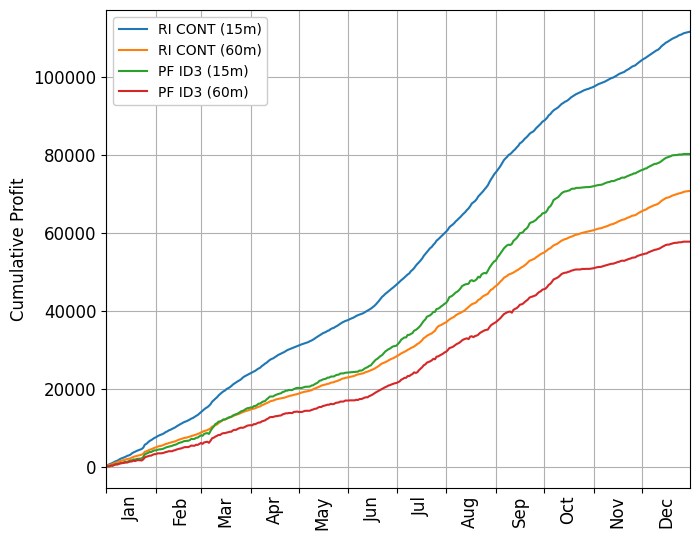

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7.1, 5.5))
ax.grid()
ax.set_ylabel('Cumulative Profit', fontsize=12)
ax.plot(results)
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter("%b"))
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False, rotation=90, labelsize=12)
ax.set_xlim([pd.Timestamp("2022-01-01"), pd.Timestamp("2022-12-31")])
for label in ax.get_xticklabels(minor=True):
    label.set_horizontalalignment('center')
ax.legend(results.columns, loc='upper left', frameon=True, fontsize=10, framealpha=1)
fig.tight_layout()

output_path = os.path.join("output", "plots")
if not os.path.exists(output_path):
    os.makedirs(output_path)
fig.savefig(os.path.join(output_path, 'revenue_plot_2022.png'), dpi=300, bbox_inches="tight")

In [14]:
rib_15_ppc = rib_15_revenues.profit.sum() / rib_15_revenues.cycles.sum()
rib_15_profit_mean = rib_15_revenues.profit.mean()

rib_60_ppc = rib_60_revenues.profit.sum() / rib_60_revenues.cycles.sum()
rib_60_profit_mean = rib_60_revenues.profit.mean()
table_data = load_table_data()
table_data.drop_duplicates(inplace=True)
latex_table = table_data.copy()
latex_table = latex_table[(latex_table.cycle == 365) & (latex_table.rto == 0.86) & (latex_table.c_rate == 0.5)]
latex_table.set_index('Model', inplace=True)
latex_table['PPC (Eur / Cycle)'] = latex_table.revenue / latex_table.cycle
latex_table.loc['RI CONT (15m)', 'revenue'] = rib_15_revenues.profit.sum()
latex_table.loc['RI CONT (60m)', 'revenue'] = rib_60_revenues.profit.sum()
latex_table.loc['RI CONT (15m)', 'PPC (Eur / Cycle)'] = rib_15_ppc
latex_table.loc['RI CONT (60m)', 'PPC (Eur / Cycle)'] = rib_60_ppc

latex_table = latex_table.round(2)
result_table = latex_table[['revenue', "PPC (Eur / Cycle)"]].loc[['RI CONT (15m)', 'RI CONT (60m)', 'PF ID3 (15m)', 'PF ID3 (60m)']]

In [15]:
print(result_table.to_latex(float_format="%.2f"))

\begin{tabular}{lrr}
\toprule
 & revenue & PPC (Eur / Cycle) \\
Model &  &  \\
\midrule
RI CONT (15m) & 111631.86 & 305.84 \\
RI CONT (60m) & 70749.62 & 193.83 \\
PF ID3 (15m) & 80244.57 & 219.85 \\
PF ID3 (60m) & 57731.58 & 158.17 \\
\bottomrule
\end{tabular}



In [16]:
result_table

,revenue,PPC (Eur / Cycle)
Model,,
RI CONT (15m),111631.86,305.84
RI CONT (60m),70749.62,193.83
PF ID3 (15m),80244.57,219.85
PF ID3 (60m),57731.58,158.17
